In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
plt.style.use('./grl.mplstyle')

%load_ext autoreload
%autoreload 3
    
DATAPATH = '/scratch/jw8736/ctr/outputs/'

In [7]:
''' Load all 3D fields together. '''

import os
import glob

# Path to data files
path = DATAPATH + 'CU4/netcdf/'
files = sorted(glob.glob(os.path.join(path, 'field_eta_t*.nc')))  # Use wildcard to find all matching files

# Parsing the filename to get a time
def preprocess(ds, fname):
    t = float(os.path.basename(fname).split('_t')[1].split('.nc')[0])
    ds = ds.expand_dims({'t': [t]})  # Add new dimension 'year'
    return ds

# Use open_mfdataset with preprocess function and the wildcard
ds = xr.open_mfdataset(files, concat_dim='t', combine='nested', preprocess=lambda ds: preprocess(ds, ds.encoding['source']),
                       chunks={'x':-1,'z':-1,'y':-1})

# We transform y coordinate!
wl = 2*np.pi/4
ds['y'] = (ds['y'] - 1) / wl
print(ds)

<xarray.Dataset>
Dimensions:  (t: 20, z: 512, x: 512, y: 512)
Coordinates:
  * t        (t) float64 39.0 40.0 41.0 42.0 43.0 ... 54.0 55.0 56.0 57.0 58.0
  * x        (x) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
  * y        (y) float64 -0.6327 -0.6249 -0.6171 -0.6093 ... 3.344 3.352 3.359
  * z        (z) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
Data variables:
    ux       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uy       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uz       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    f        (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    eta      (t, z, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    phase    (t, x) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    start_time:  40
    ak:          0.2
    k:  

In [3]:
ds.attrs['start_time']

40

In [16]:
k = 4
T = 2*2*np.pi/k/12
print(T)

0.2617993877991494


Text(0, 0.5, '$\\overline{u ^{\\prime} w ^{\\prime} }/u_*^2$')

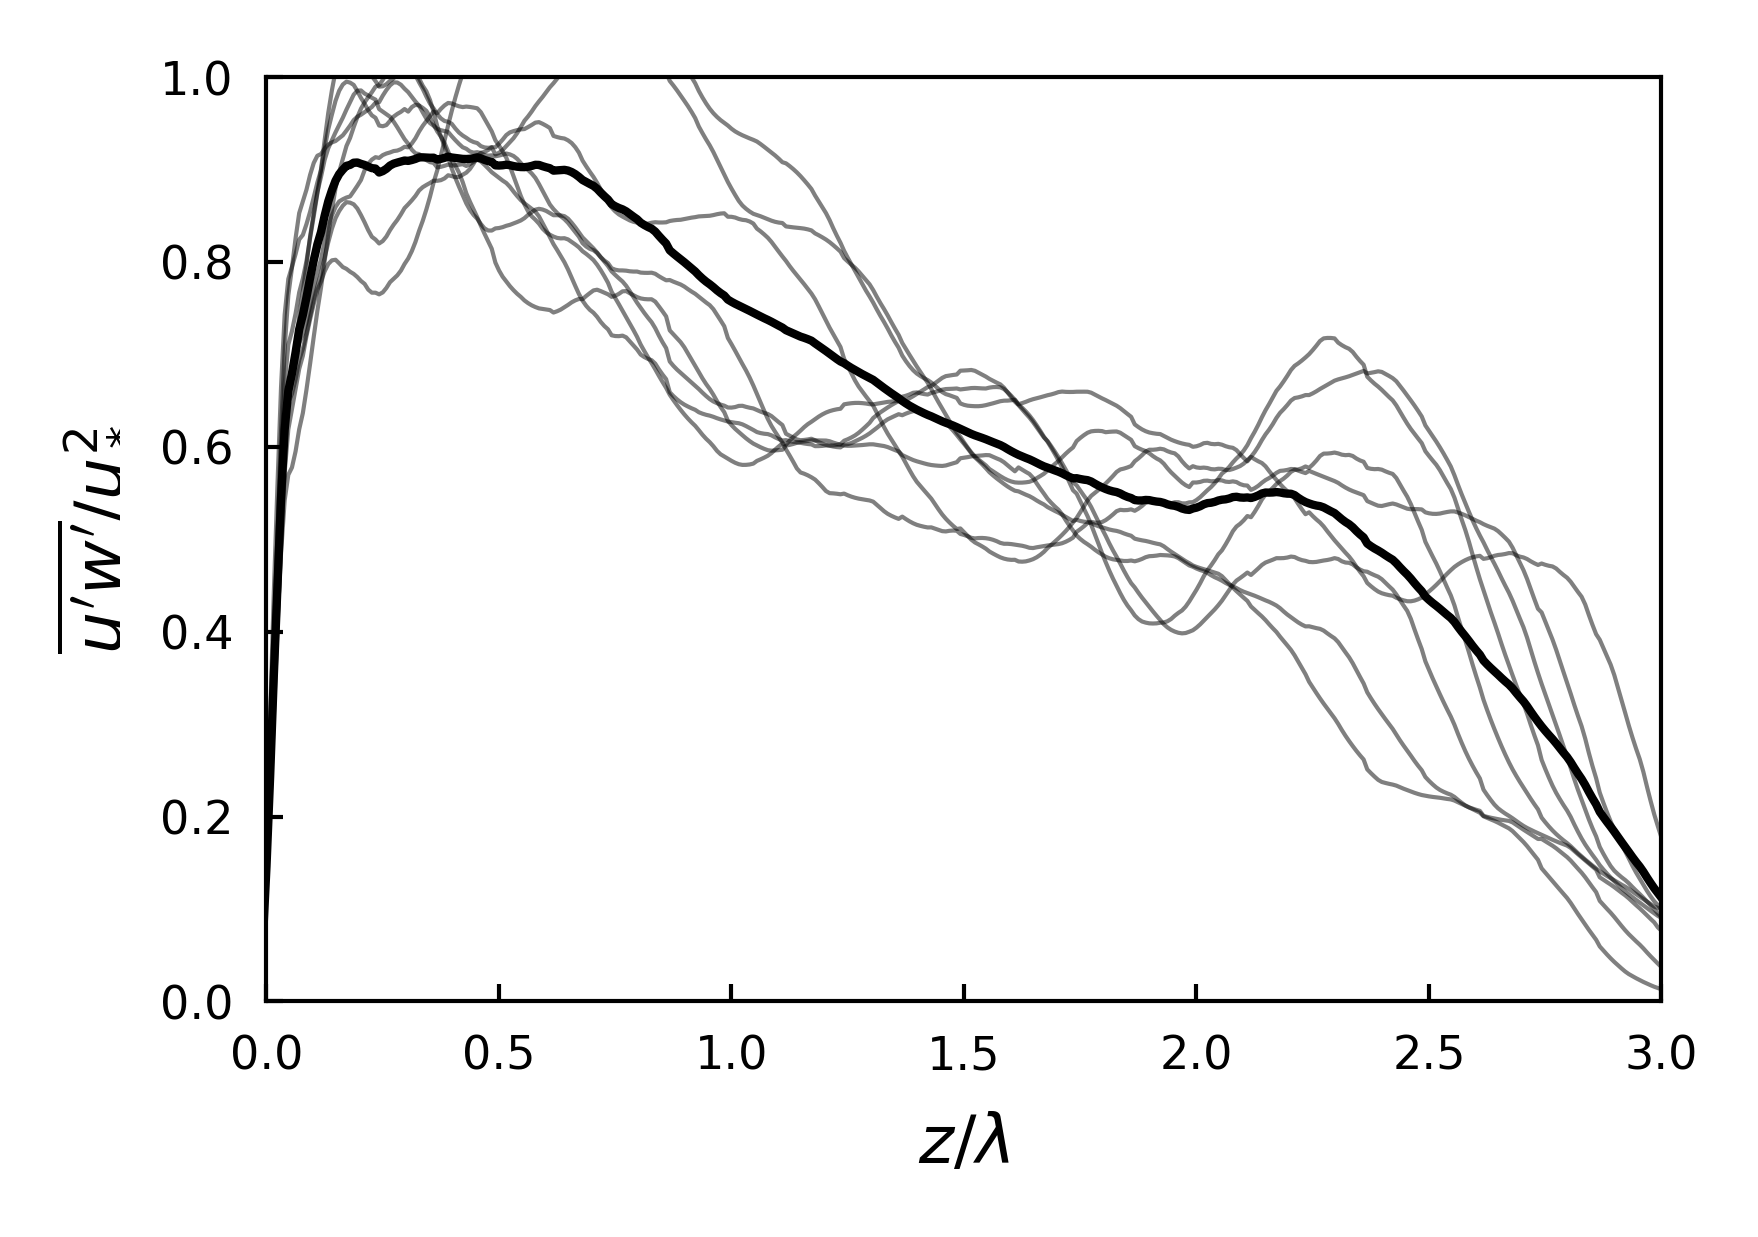

In [4]:
wl = 2*np.pi/4

fig = plt.figure(figsize=[3,2]); ax = plt.gca()

# uv_bar_t = []
# with ProgressBar():
#     ux_mean = ds.ux.mean(dim=['x','z','t']).compute()
#     uy_mean = ds.uy.mean(dim=['x','z','t']).compute()
#     for t in range(50,58):
#         uv = (ds.sel(t=t).ux - ux_mean)*(ds.sel(t=t).uy - uy_mean)
#         uv_bar = uv.mean(dim=['x','z']).compute() / 0.25**2 
#         plt.plot(uv.y, -uv_bar, lw=0.5, alpha=0.5, c='k')
#         uv_bar_t.append(uv_bar)

for uv_bar in uv_bar_t:
    plt.plot(uv.y, -uv_bar, lw=0.5, alpha=0.5, c='k')

uv = (ds.ux - ux_mean)*(ds.uy - uy_mean)
uv_bar = uv.sel(t=slice(50,58)).mean(dim=['x','z','t']).compute() / 0.25**2 
plt.plot(uv.y, -uv_bar, lw=1, c='k')

ax.set_ylim([0,1]); ax.set_xlim([0,3])
ax.set_xlabel(r'$z/\lambda$'); ax.set_ylabel(r'$\overline{u ^{\prime} w ^{\prime} }/u_*^2$')

In [6]:
uv_bar.name = "uv_bar"
uv_bar.to_netcdf('CU4_50to58.nc')

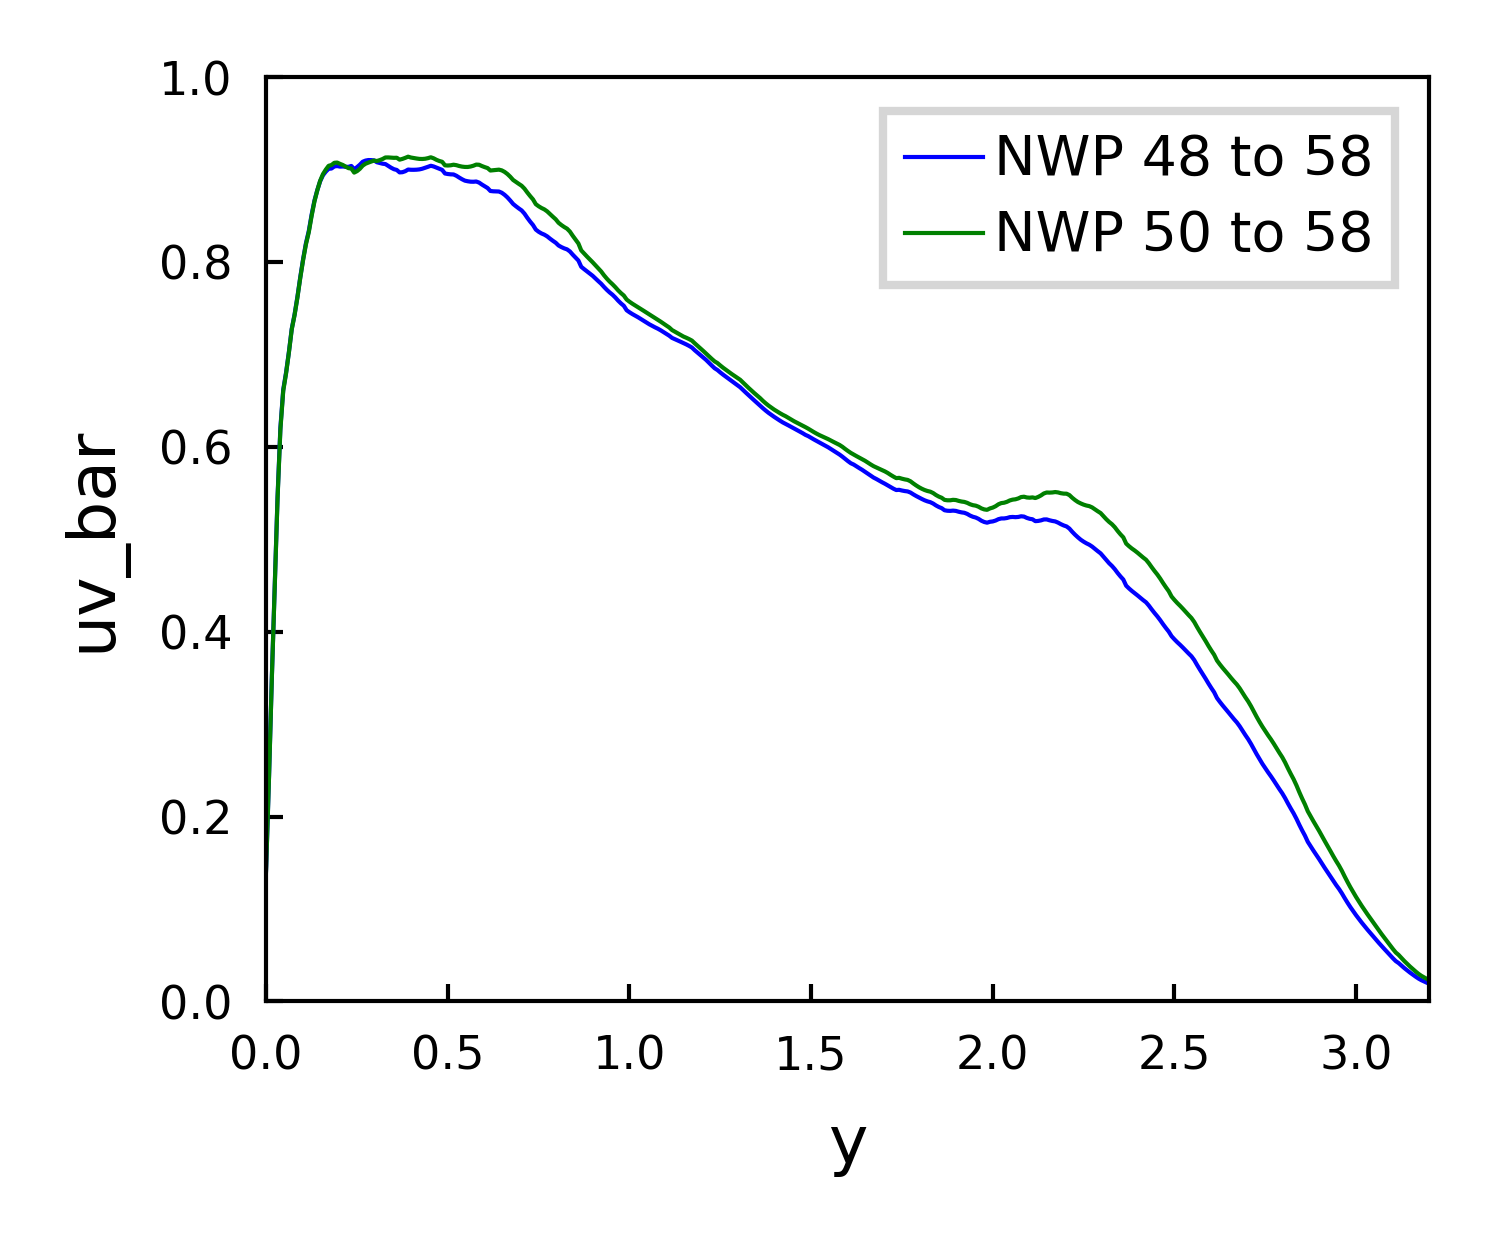

In [21]:
# uv_bar1 = xr.load_dataset('NWP_CU4_48to58.nc')
# uv_bar2 = xr.load_dataset('NWP_CU4_50to58.nc')
# uv_bar1 = uv_bar1.rename({"__xarray_dataarray_variable__": "uv_bar"})
# uv_bar2 = uv_bar2.rename({"__xarray_dataarray_variable__": "uv_bar"})

plt.figure(figsize=[2.5,2]); ax = plt.gca()

(-uv_bar1.uv_bar).plot(label='NWP 48 to 58')
(-uv_bar2.uv_bar).plot(label='NWP 50 to 58')

ax.set_ylim([0,1]); ax.set_xlim([0,3.2])
plt.legend()

In [19]:
# Add a time dimension and metadata and save to netcdf
# ds = ds.expand_dims({'t': np.float64([tsimu-case.tstart])})
# ds = ds.assign_attrs(
#     ustar=case.ustar, Retau=case.Retau, Bo=case.Bo, g=case.g, 
#     ak=case.ak, LEVEL=case.LEVEL, emax=case.emax, alterMU=case.alterMU, 
#     folder=case.path, tstart=case.tstart
# )

In [38]:
field = 'uy'
wl = 2*np.pi/4 ; 
# y_ = 0.1
# ysel = wl*y_ + 1

nbins = 32
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2
q_centers = []

with ProgressBar():
    for yi in range(81,82):
        print(yi)
        ds_ = ds.isel(y=yi).sel(t=slice(50,58))#.load()
        lox = ds_[field].groupby_bins(ds_.phase, bins=bins).mean().mean(['z'])
        print(lox.values)



81
[########################################] | 100% Completed | 101.39 ms
[                                        ] | 0% Completed | 105.74 ms

/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


[########################################] | 100% Completed | 23.71 s
[-0.03844582 -0.05774716 -0.07385248 -0.0830842  -0.09184609 -0.10724093
 -0.13617143 -0.17966786 -0.19220418 -0.18220752 -0.16682541 -0.14425147
 -0.11798985 -0.08732392 -0.05386375 -0.0179723   0.01793552  0.05365855
  0.08713129  0.11749776  0.14539185  0.167409    0.1822595   0.19136308
  0.18825534  0.16809687  0.14518571  0.12115921  0.09042399  0.05492858
  0.02032216 -0.01328023]


In [50]:
wl = 2*np.pi/4

nbins = 64
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2
q_centers = []

ds_ = ds.sel(t=slice(50,58))
ux_wave = ds_['ux'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z'])
uy_wave = ds_['uy'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z'])

/ext3/miniconda3/lib/python3.11/site-packages/xarray/core/dataset.py:4597: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})
/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/ext3/miniconda3/lib/python3.11/site-packages/xarray/core/dataset.py:4597: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning

In [58]:
with ProgressBar():
    uv = (ds_.ux - ux_wave.mean('phase_bins'))*(ds.uy - uy_wave.mean('phase_bins'))
    uv_bar = uv.mean(dim=['x','z','t']).compute()

[########################################] | 100% Completed | 60.67 s


In [77]:
##### Old code of computing phase-binned velocity. Was too slow. #####
# with ProgressBar():
#     for yi in range(81,82):
#         print(yi)
#         lox2 = []
#         ds_ = ds.isel(y=yi).sel(t=slice(50,58)).load()
#         phase = ds_.phase.compute()
#         for i in range(len(bin_centers)):
#             q = ds_[field].where((phase > bins[i])&((phase < bins[i+1])),drop=True)
#             lox2.append(q.mean(dim=['t','x','z']).values.squeeze())
#         print(lox2)

In [7]:
import pickle

q = np.array(q_centers).reshape(-1,32) # filled row by row
output = open('q_CU4.pkl', 'wb')
pickle.dump(q, output)

# for yi in range(81,200)
# q.shape (119, 32)

# pkl = open('q.pkl', 'rb')
# qcenters = pickle.load(pkl)

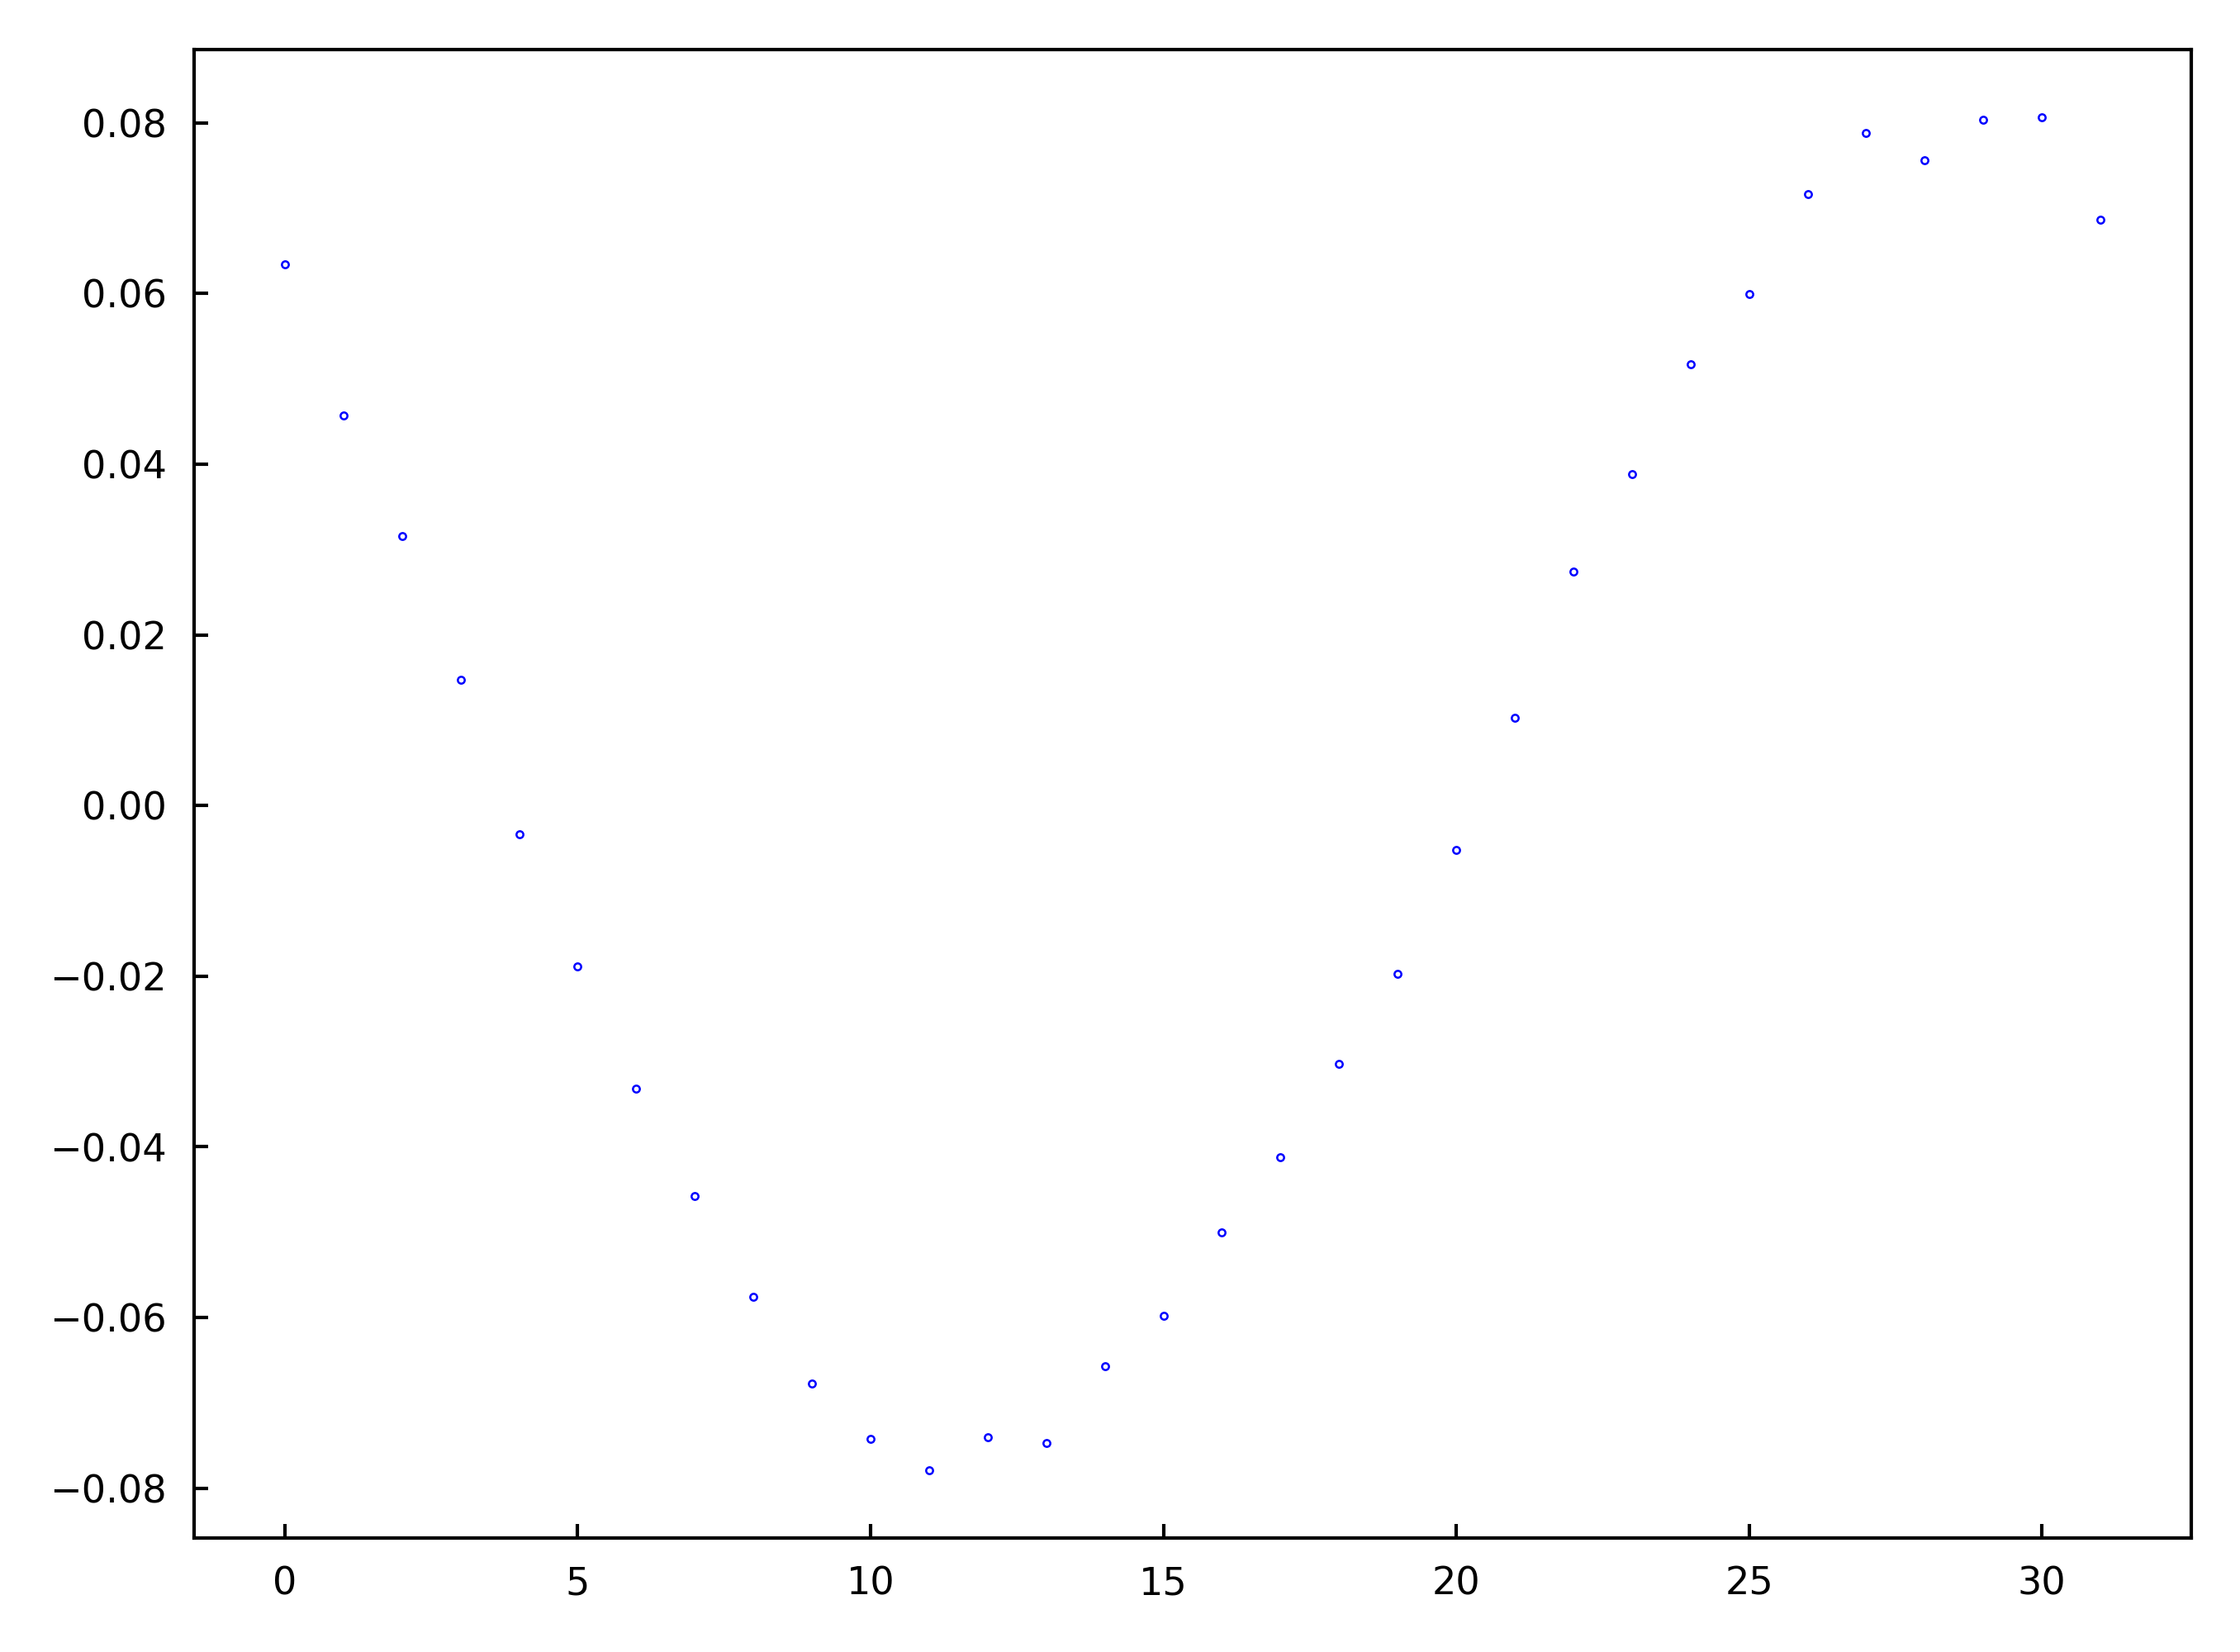

In [8]:
plt.plot(q[30]-np.array(q[30]).mean(),'.',)

45
50
55


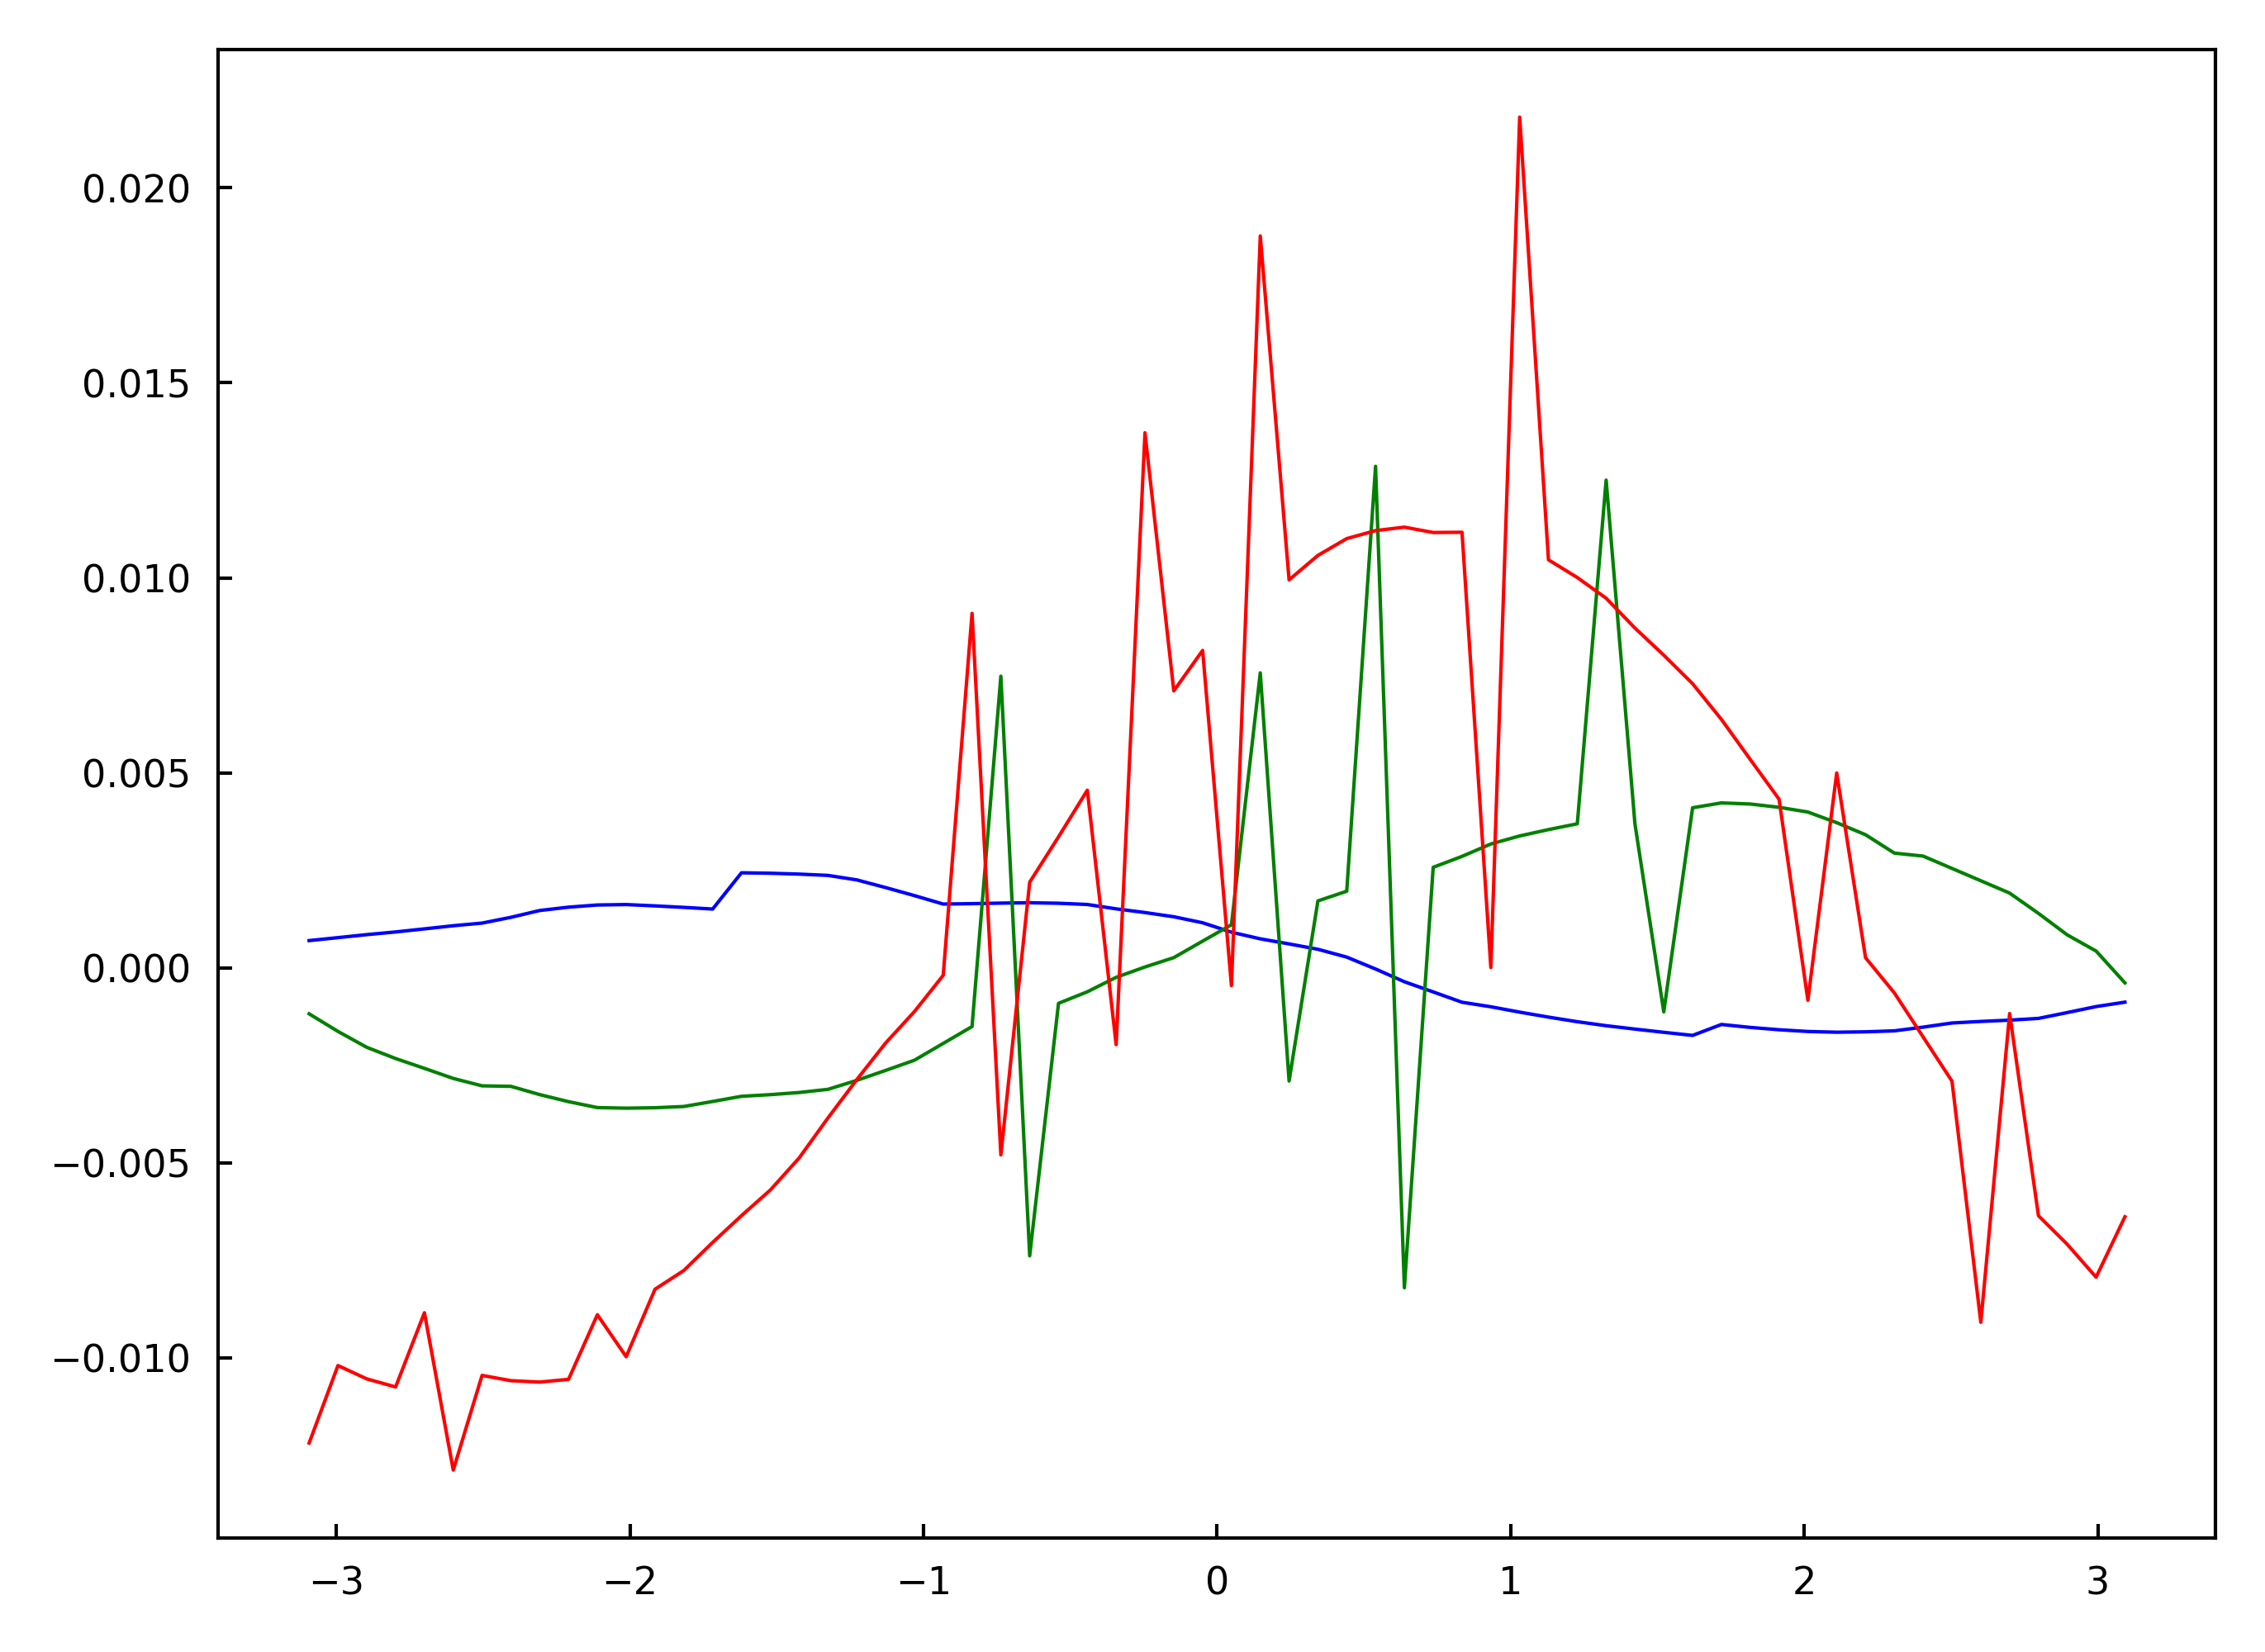

In [24]:
field = 'uy'
wl = 2*np.pi/4 ; y_ = 1
ysel = wl*y_ + 1

nbins = 64
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2

for tsel in (45,50,55):
    print(tsel)
    q_centers = []
    for i in range(len(bin_centers)):
        ds_ = ds.sel(t=tsel, method='nearest').sel(y=ysel, method='nearest')
        q = ds_[field].where((ds_.phase.compute() > bins[i])&((ds_.phase.compute() < bins[i+1])),drop=True)
        q_centers.append(q.mean(dim=['x','z']).values.squeeze())
    plt.plot(bin_centers, q_centers)

(-0.1, 0.1)

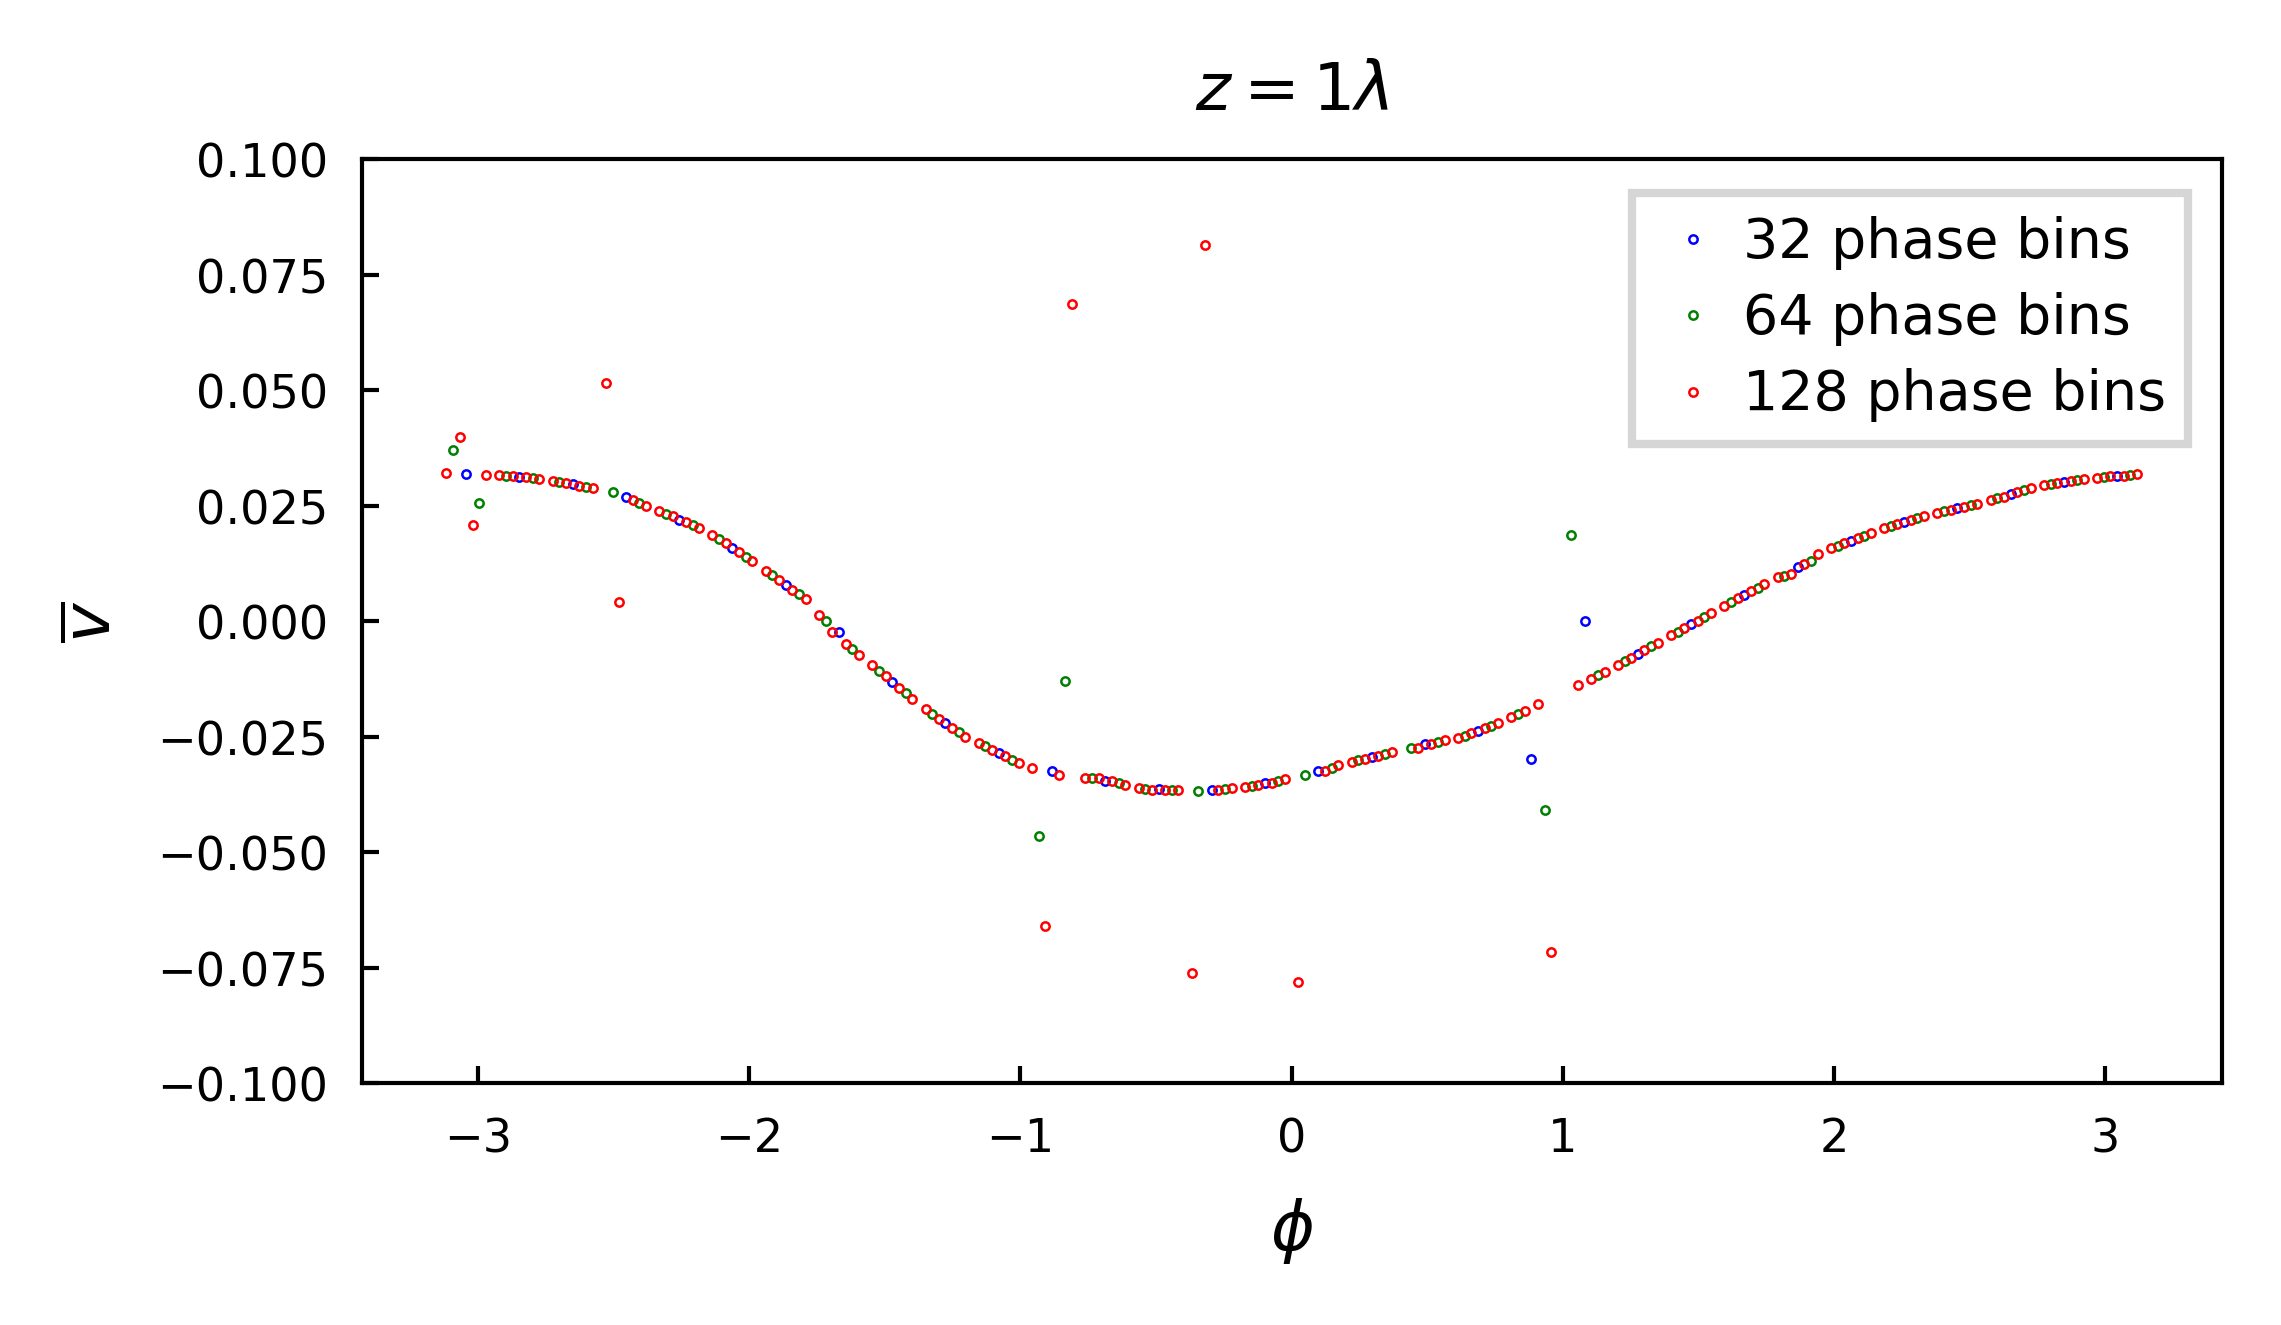

In [74]:
field = 'uy'
wl = 2*np.pi/4 ; y_ = 1
ysel = wl*y_ + 1

plt.figure (figsize=[4,2])

nbins = 32
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2
q_centers = []

for i in range(len(bin_centers)):
    q = ds[field].sel(y=ysel, method='nearest').where((ds.phase > bins[i])&((ds.phase < bins[i+1])),drop=True).mean(dim=['x','z'])
    q_centers.append(q.values.squeeze())
    
plt.plot(bin_centers, q_centers, '.', label='32 phase bins')


nbins = 64
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2
q_centers = []

for i in range(len(bin_centers)):
    q = ds[field].sel(y=ysel, method='nearest').where((ds.phase > bins[i])&((ds.phase < bins[i+1])),drop=True).mean(dim=['x','z'])
    q_centers.append(q.values.squeeze())
    
plt.plot(bin_centers, q_centers, '.', label='64 phase bins')

nbins = 128
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2
q_centers = []

for i in range(len(bin_centers)):
    q = ds[field].sel(y=ysel, method='nearest').where((ds.phase > bins[i])&((ds.phase < bins[i+1])),drop=True).mean(dim=['x','z'])
    q_centers.append(q.values.squeeze())
    
plt.plot(bin_centers, q_centers, '.', label='128 phase bins')

plt.xlabel(r'$\phi$'); plt.ylabel(r'$\overline{v}$')
plt.legend(); plt.title(r'$z=%g\lambda$' %y_)
plt.ylim([-0.1,0.1])

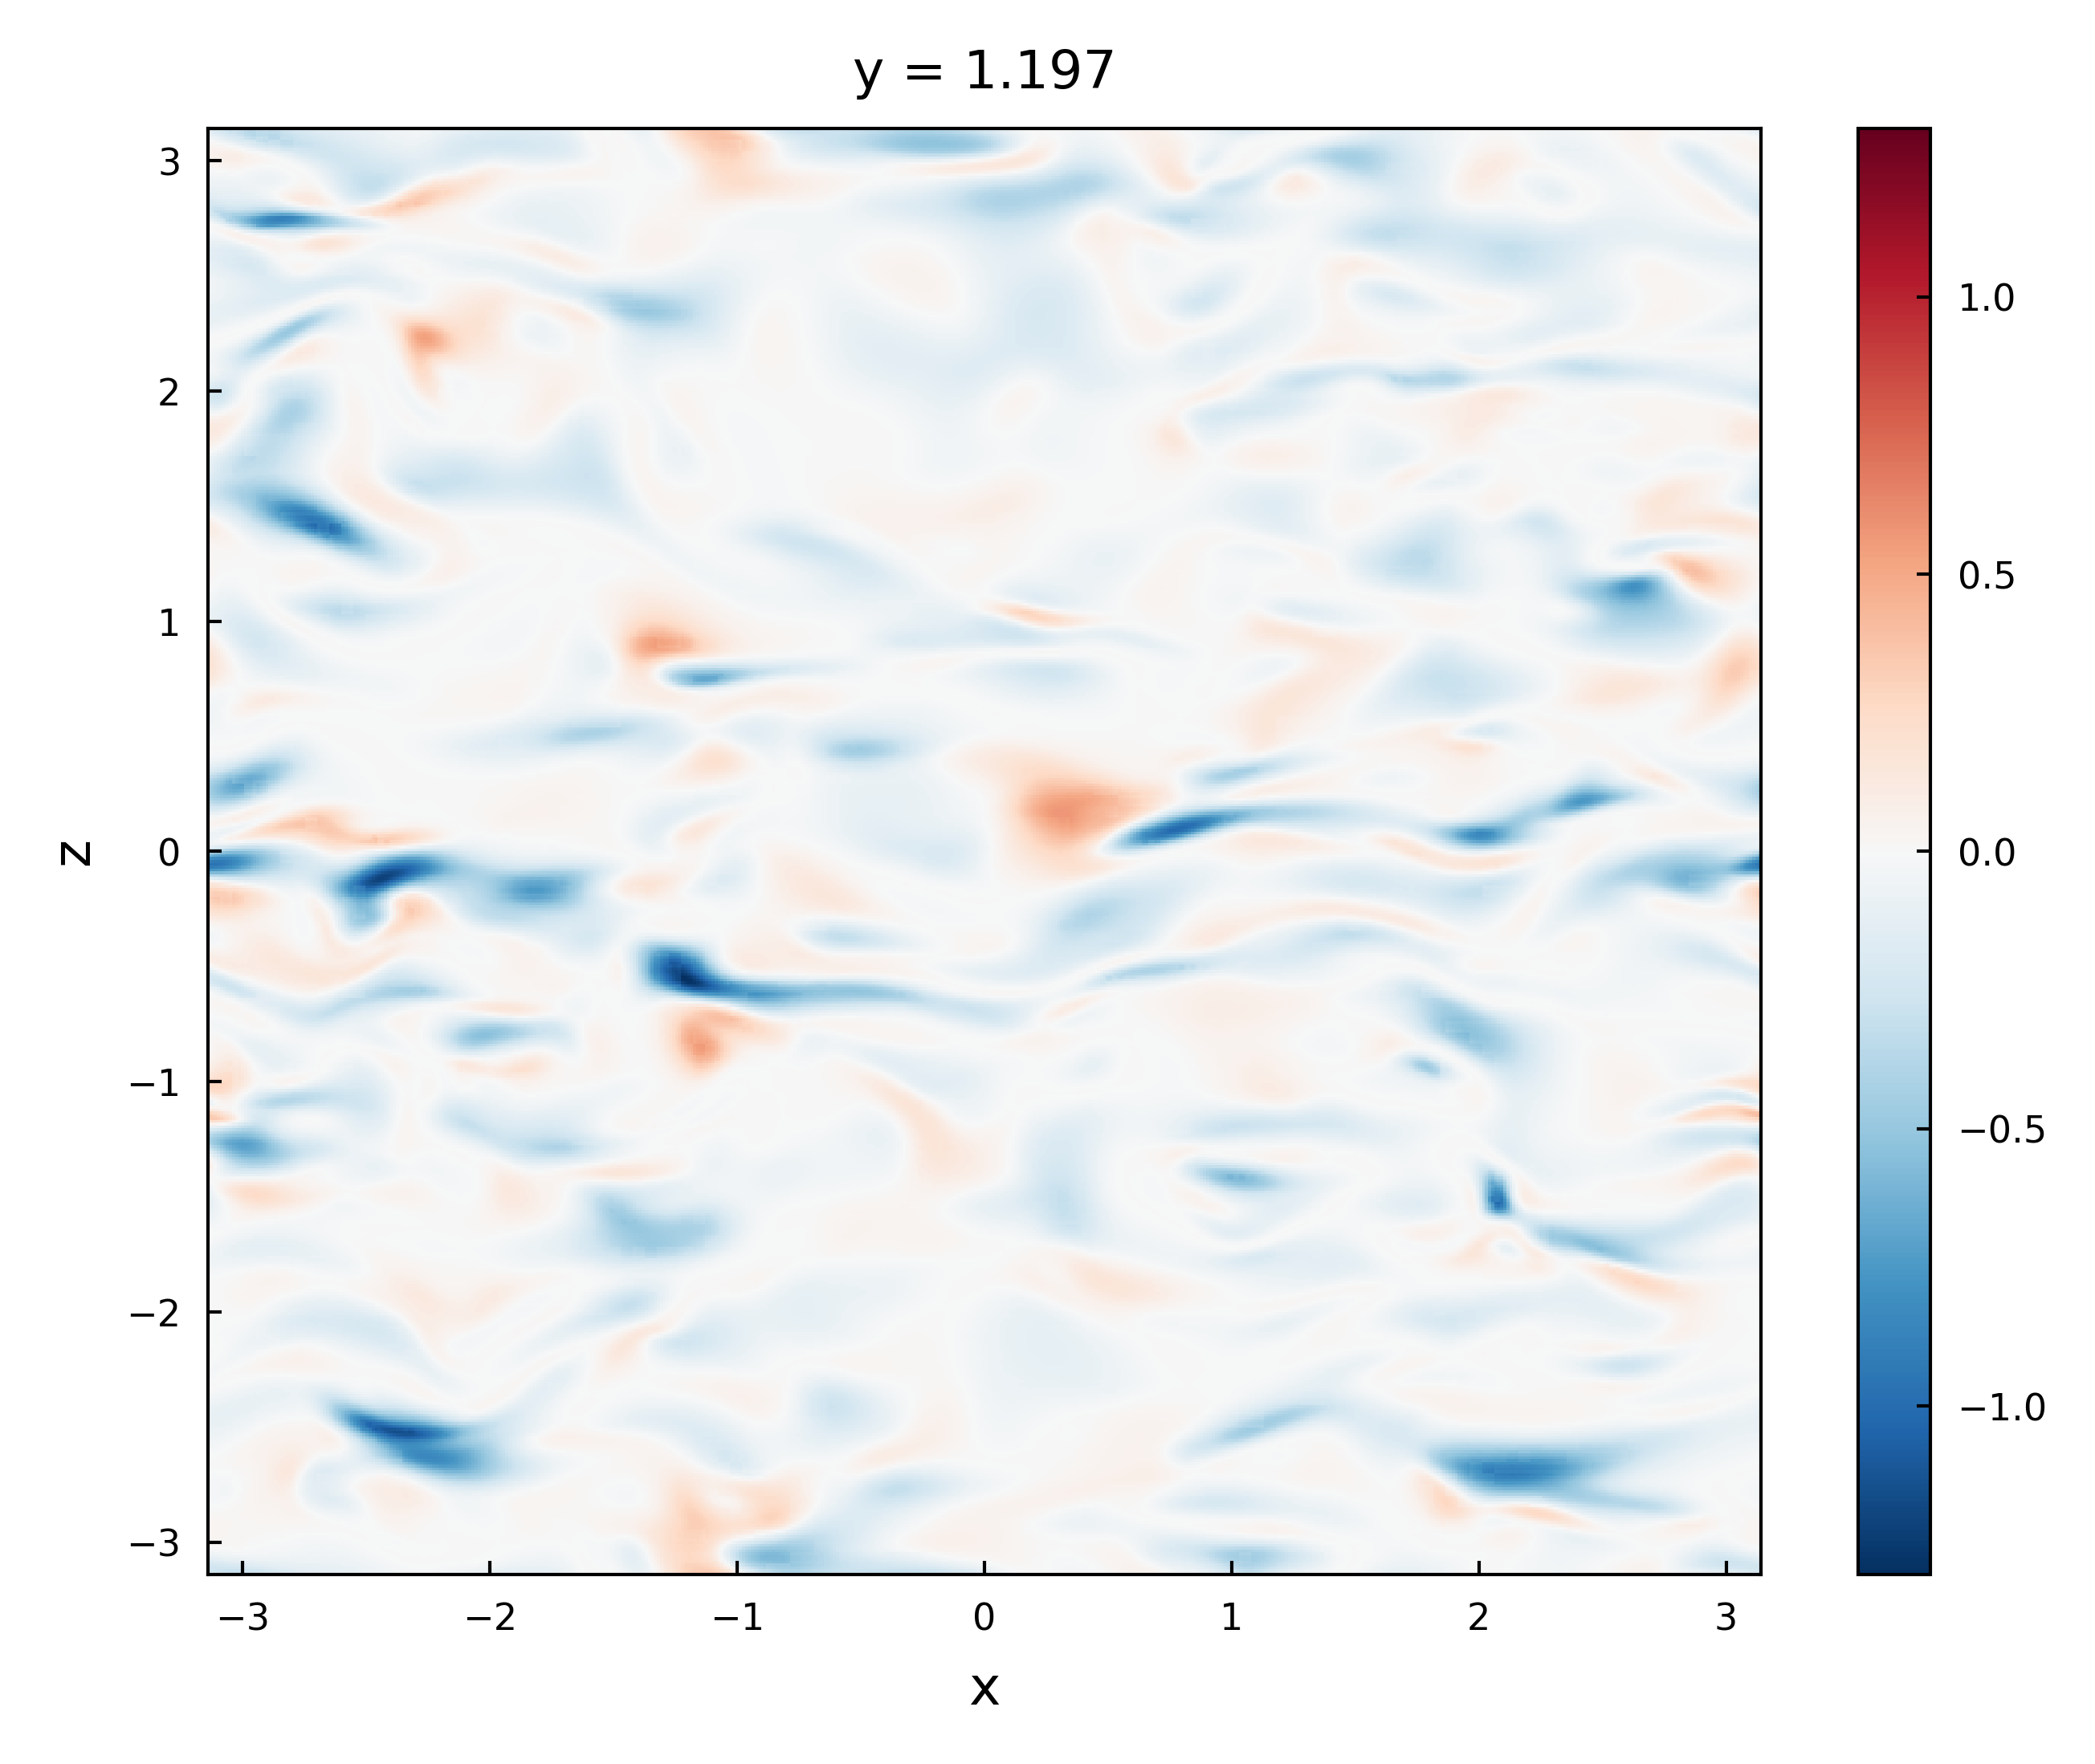

In [30]:
uv = (ds.ux - ds.ux.mean(dim=['x','z']))*(ds.uy - ds.uy.mean(dim=['x','z']))
uv.sel(y=1.2, method='nearest').plot(x='x')

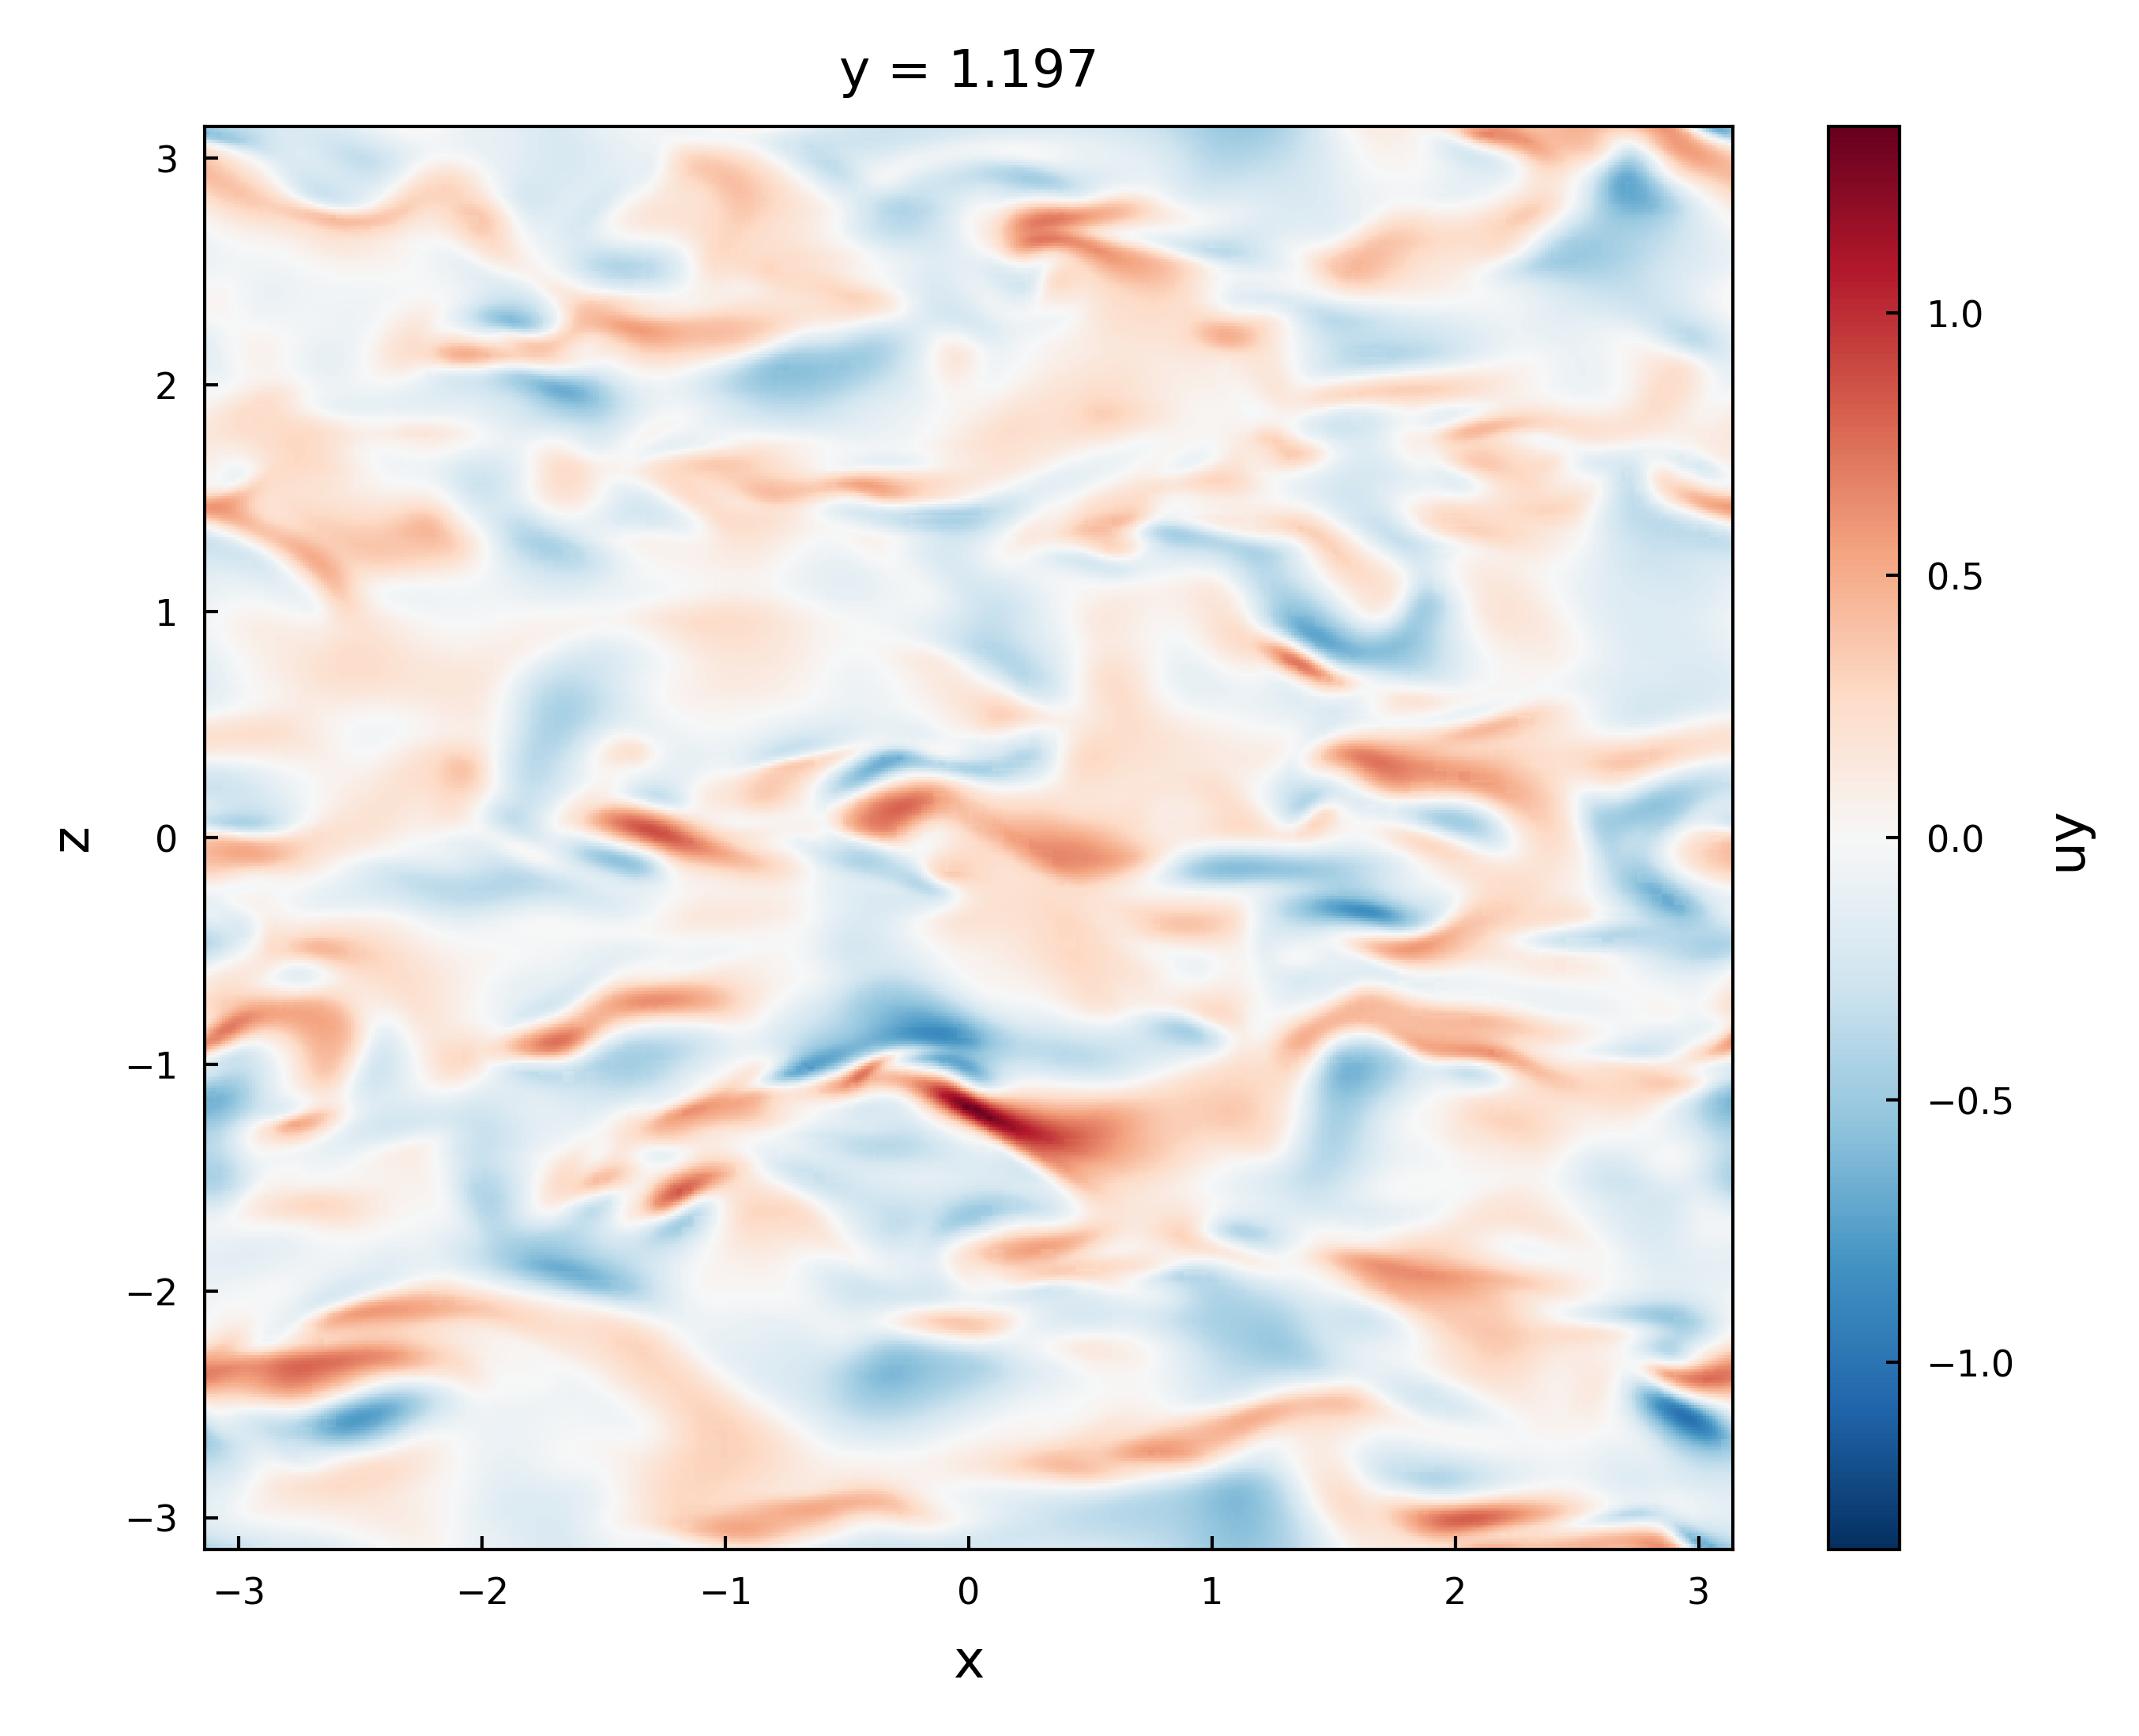

In [29]:
ds_nwp.uy.sel(y=1.2, method='nearest').plot(x='x')

In [ ]:
ds.uy.sel(y=1, method='nearest').plot(x='x')